In [1]:
import numpy as np
import torch as torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
device = "cuda:2"

In [3]:
def trainer(model, gener, iters, opt, loss_fn, verbose= True, non_lin = False, device= "cuda:2"):        
    for i in tqdm(range(iters), desc = 'Progress Bar'):
        (X, Y) = gener.get_test(64)
        preds= model(torch.tensor(X, device = device, dtype= torch.float32), non_lin = non_lin)
        loss= loss_fn(preds.transpose(1, 2), torch.tensor(Y, device = device))

        loss.backward()
        opt.step()
        opt.zero_grad()


        if i%5000 == 0 and verbose:  
            with torch.no_grad():
                (X_train, Y_train) = gener.get_train(10000)
                preds_train= torch.argmax(model(torch.tensor(X_train, device = device, dtype= torch.float32), non_lin = non_lin), dim = 2)
                train_acc = (torch.sum(1*(preds_train == torch.tensor(Y_train, device = device)))/2e5).detach().cpu().numpy()

                (X_valid, Y_valid) = gener.get_test(10000)
                preds_valid= torch.argmax(model(torch.tensor(X_valid, device = device, dtype= torch.float32), non_lin = non_lin), dim = 2)
                test_acc = (torch.sum(1*(preds_valid == torch.tensor(Y_valid, device = device)))/2e5).detach().cpu().numpy()

            print("step %i: loss = %f, train_acc= %f, test_acc= %f"%(i, loss, train_acc, test_acc))
            torch.save({"model": model.state_dict(),
                        "opt": opt.state_dict(),
                        "num_train": i}, "./Sorting_limited.tar")
    print("final loss= %f"%(loss.detach().cpu().numpy()))

    
class MultiHeadAttention_wOhead(nn.Module):
    def __init__(self, seq_len, input_dim, output_dim, attn_dim, num_heads):
        super().__init__()
        embed_dim = input_dim
        assert attn_dim % num_heads == 0
        
        self.embed= nn.Linear(input_dim, embed_dim, bias = False)
        self.P = nn.Parameter(torch.randn(seq_len, embed_dim), requires_grad= True)
        self.key = nn.Linear(embed_dim, attn_dim, bias = False)
        self.query = nn.Linear(embed_dim, attn_dim, bias = False)
        self.value = nn.Linear(embed_dim, attn_dim, bias = False)
        self.proj = nn.Linear(attn_dim, output_dim, bias = False)

        self.n_head = num_heads
        self.seq_len = seq_len
        self.input_dim= input_dim
        self.attn_dim = attn_dim

    def forward(self, input, non_lin = True):
        N, S, E = input.shape
        assert (S, E) == (self.seq_len, self.input_dim), "Wrong input!"

        # X = self.embed(input) + self.P
        X = input

        Q = torch.reshape(self.query(X), (N, self.seq_len, self.n_head, self.attn_dim//self.n_head)).transpose(1 , 2)
        K = torch.reshape(self.key(X), (N, self.seq_len, self.n_head, self.attn_dim//self.n_head)).transpose(1, 2)
        V = torch.reshape(self.value(X), (N, self.seq_len, self.n_head, self.attn_dim//self.n_head)).transpose(1, 2)
        scores= torch.matmul(Q, torch.transpose(K, 3, 2))/(self.attn_dim//self.n_head)**0.5
        
        if non_lin:
            scores= torch.softmax(scores, dim = 3)
        
        Y1 = torch.matmul(scores, V).transpose(1, 2).reshape(N, self.seq_len, self.attn_dim)
        out_att = self.proj(Y1)

        return out_att
    
    
class sort_limited():
    def __init__(self, leng, ran, num_train = 50000):
        self.len = leng
        self.ran= ran
        self.num_train = num_train

    def get_leveled(self, num_swaps, b):
        sorted_seq = np.sort(np.random.choice(self.ran, [b, self.len]))
        seq = np.copy(sorted_seq)
        for _ in np.arange(num_swaps):
            i = np.random.randint(self.len-1, size= (b,))
            t= seq[np.arange(b), i]
            seq[np.arange(b), i] = seq[np.arange(b), i+1]
            seq[np.arange(b), i+1] = t
        
        indices = np.argsort(seq)
        seq = np.eye(self.ran)[seq]

        return seq, indices
    
    def get_test(self, b):
        seq= np.random.choice(self.ran, [b, self.len])
        sorted_seq = np.argsort(np.argsort(seq, axis = 1))
        seq = np.eye(self.ran)[seq]
        
        return seq, sorted_seq
    
    def get_train(self, b):
        train_list = np.random.choice(self.num_train, b, replace= True)
        seq = []
        for i in train_list:
            np.random.seed(i)
            seq.append(np.random.choice(self.ran, (self.len)))
        np.random.seed()
        seq = np.stack(seq, axis = 0)
        sorted_seq = np.argsort(np.argsort(seq, axis = 1))
        seq = np.eye(self.ran)[seq]
        
        return seq, sorted_seq

In [4]:
lr= 5e-4
tran = MultiHeadAttention_wOhead(20, 200, 20, 32, 1)
tran.to(device= device)
gener= sort_limited(20, 200, 3000)
opt = torch.optim.Adam(tran.parameters(), lr= lr)
loss_fn = nn.CrossEntropyLoss()
print("learning rate= ", (lr))
trainer(tran, gener, 250000, opt, loss_fn, verbose= True, non_lin= False)

learning rate=  0.0005


Progress Bar:   0%|                                                                                                                                                       | 14/250000 [00:02<8:09:26,  8.51it/s]

step 0: loss = 2.995731, train_acc= 0.050140, test_acc= 0.050520


Progress Bar:   2%|███                                                                                                                                                    | 5025/250000 [00:32<48:45, 83.75it/s]

step 5000: loss = 1.024872, train_acc= 0.576565, test_acc= 0.573640


Progress Bar:   4%|██████                                                                                                                                                | 10024/250000 [01:02<40:52, 97.84it/s]

step 10000: loss = 0.647409, train_acc= 0.748565, test_acc= 0.753720


Progress Bar:   6%|█████████                                                                                                                                             | 15018/250000 [01:32<57:32, 68.07it/s]

step 15000: loss = 0.445547, train_acc= 0.846400, test_acc= 0.844410


Progress Bar:   8%|███████████▉                                                                                                                                         | 20033/250000 [01:56<26:23, 145.21it/s]

step 20000: loss = 0.252672, train_acc= 0.894035, test_acc= 0.892920


Progress Bar:  10%|███████████████                                                                                                                                       | 25023/250000 [02:25<45:53, 81.71it/s]

step 25000: loss = 0.245873, train_acc= 0.913290, test_acc= 0.912460


Progress Bar:  12%|██████████████████                                                                                                                                    | 30017/250000 [02:57<39:12, 93.49it/s]

step 30000: loss = 0.298701, train_acc= 0.919585, test_acc= 0.918135


Progress Bar:  14%|█████████████████████                                                                                                                                 | 35018/250000 [03:29<52:52, 67.75it/s]

step 35000: loss = 0.211404, train_acc= 0.922265, test_acc= 0.920520


Progress Bar:  16%|████████████████████████                                                                                                                              | 40026/250000 [04:04<56:51, 61.56it/s]

step 40000: loss = 0.181410, train_acc= 0.923585, test_acc= 0.924745


Progress Bar:  18%|██████████████████████████▊                                                                                                                          | 45052/250000 [04:27<26:18, 129.88it/s]

step 45000: loss = 0.224617, train_acc= 0.924455, test_acc= 0.924575


Progress Bar:  20%|█████████████████████████████▊                                                                                                                       | 50034/250000 [04:47<22:36, 147.45it/s]

step 50000: loss = 0.194248, train_acc= 0.924265, test_acc= 0.924915


Progress Bar:  22%|████████████████████████████████▊                                                                                                                    | 55027/250000 [05:16<30:53, 105.20it/s]

step 55000: loss = 0.289708, train_acc= 0.924810, test_acc= 0.927660


Progress Bar:  24%|████████████████████████████████████                                                                                                                  | 60022/250000 [05:49<45:34, 69.48it/s]

step 60000: loss = 0.204968, train_acc= 0.926520, test_acc= 0.925870


Progress Bar:  26%|███████████████████████████████████████                                                                                                               | 65023/250000 [06:21<36:22, 84.76it/s]

step 65000: loss = 0.235120, train_acc= 0.929685, test_acc= 0.926050


Progress Bar:  28%|██████████████████████████████████████████                                                                                                            | 70024/250000 [06:54<37:21, 80.28it/s]

step 70000: loss = 0.197776, train_acc= 0.926760, test_acc= 0.926610


Progress Bar:  30%|████████████████████████████████████████████▋                                                                                                        | 75024/250000 [07:23<28:16, 103.17it/s]

step 75000: loss = 0.332044, train_acc= 0.926815, test_acc= 0.925965


Progress Bar:  32%|███████████████████████████████████████████████▋                                                                                                     | 80032/250000 [07:47<26:06, 108.49it/s]

step 80000: loss = 0.182142, train_acc= 0.927855, test_acc= 0.926880


Progress Bar:  34%|██████████████████████████████████████████████████▋                                                                                                  | 85034/250000 [08:12<25:25, 108.13it/s]

step 85000: loss = 0.215917, train_acc= 0.927165, test_acc= 0.925640


Progress Bar:  36%|█████████████████████████████████████████████████████▋                                                                                               | 90033/250000 [08:36<24:01, 110.97it/s]

step 90000: loss = 0.190925, train_acc= 0.928310, test_acc= 0.925575


Progress Bar:  38%|█████████████████████████████████████████████████████████                                                                                             | 95024/250000 [09:03<39:22, 65.59it/s]

step 95000: loss = 0.173978, train_acc= 0.928050, test_acc= 0.926960


Progress Bar:  40%|███████████████████████████████████████████████████████████▌                                                                                         | 100011/250000 [09:34<39:24, 63.43it/s]

step 100000: loss = 0.184299, train_acc= 0.928680, test_acc= 0.926980


Progress Bar:  42%|██████████████████████████████████████████████████████████████▌                                                                                      | 105029/250000 [10:09<29:43, 81.30it/s]

step 105000: loss = 0.183456, train_acc= 0.927625, test_acc= 0.927385


Progress Bar:  44%|█████████████████████████████████████████████████████████████████▌                                                                                   | 110023/250000 [10:41<28:55, 80.67it/s]

step 110000: loss = 0.164943, train_acc= 0.928575, test_acc= 0.927625


Progress Bar:  46%|████████████████████████████████████████████████████████████████████▌                                                                                | 115024/250000 [11:13<25:56, 86.70it/s]

step 115000: loss = 0.200929, train_acc= 0.927635, test_acc= 0.928780


Progress Bar:  48%|███████████████████████████████████████████████████████████████████████▌                                                                             | 120021/250000 [11:46<27:30, 78.75it/s]

step 120000: loss = 0.195764, train_acc= 0.928670, test_acc= 0.928080


Progress Bar:  50%|██████████████████████████████████████████████████████████████████████████                                                                          | 125023/250000 [12:16<20:33, 101.33it/s]

step 125000: loss = 0.177978, train_acc= 0.929260, test_acc= 0.928225


Progress Bar:  52%|█████████████████████████████████████████████████████████████████████████████▍                                                                       | 130024/250000 [12:48<28:19, 70.59it/s]

step 130000: loss = 0.186628, train_acc= 0.928495, test_acc= 0.927135


Progress Bar:  54%|████████████████████████████████████████████████████████████████████████████████▍                                                                    | 135016/250000 [13:21<23:22, 81.99it/s]

step 135000: loss = 0.194636, train_acc= 0.929150, test_acc= 0.927470


Progress Bar:  56%|███████████████████████████████████████████████████████████████████████████████████▍                                                                 | 140018/250000 [13:53<23:26, 78.20it/s]

step 140000: loss = 0.228489, train_acc= 0.930595, test_acc= 0.927955


Progress Bar:  58%|██████████████████████████████████████████████████████████████████████████████████████▍                                                              | 145017/250000 [14:26<25:28, 68.68it/s]

step 145000: loss = 0.224481, train_acc= 0.928780, test_acc= 0.926895


Progress Bar:  60%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 150028/250000 [15:01<25:20, 65.73it/s]

step 150000: loss = 0.246093, train_acc= 0.929090, test_acc= 0.927580


Progress Bar:  62%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 155032/250000 [15:33<18:19, 86.36it/s]

step 155000: loss = 0.299269, train_acc= 0.930555, test_acc= 0.929595


Progress Bar:  64%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 160025/250000 [16:04<23:44, 63.18it/s]

step 160000: loss = 0.159788, train_acc= 0.930180, test_acc= 0.928320


Progress Bar:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 165012/250000 [16:37<23:06, 61.30it/s]

step 165000: loss = 0.220730, train_acc= 0.928755, test_acc= 0.927845


Progress Bar:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 170028/250000 [17:05<10:26, 127.68it/s]

step 170000: loss = 0.185605, train_acc= 0.929210, test_acc= 0.928635


Progress Bar:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 175028/250000 [17:28<16:23, 76.19it/s]

step 175000: loss = 0.213961, train_acc= 0.929960, test_acc= 0.929360


Progress Bar:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 180031/250000 [18:01<14:50, 78.55it/s]

step 180000: loss = 0.210139, train_acc= 0.929295, test_acc= 0.929135


Progress Bar:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 185037/250000 [18:33<11:34, 93.55it/s]

step 185000: loss = 0.225855, train_acc= 0.929690, test_acc= 0.927530


Progress Bar:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 190031/250000 [19:05<09:45, 102.42it/s]

step 190000: loss = 0.170105, train_acc= 0.930390, test_acc= 0.927155


Progress Bar:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 195044/250000 [19:32<05:39, 161.85it/s]

step 195000: loss = 0.150949, train_acc= 0.928865, test_acc= 0.928235


Progress Bar:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 200036/250000 [19:52<06:12, 134.22it/s]

step 200000: loss = 0.203474, train_acc= 0.930765, test_acc= 0.929270


Progress Bar:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 205032/250000 [20:17<08:32, 87.80it/s]

step 205000: loss = 0.208951, train_acc= 0.929225, test_acc= 0.928010


Progress Bar:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 210017/250000 [20:47<10:45, 61.98it/s]

step 210000: loss = 0.175911, train_acc= 0.930135, test_acc= 0.928580


Progress Bar:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 215035/250000 [21:19<05:50, 99.66it/s]

step 215000: loss = 0.205999, train_acc= 0.929970, test_acc= 0.929530


Progress Bar:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 220017/250000 [21:50<06:28, 77.19it/s]

step 220000: loss = 0.158690, train_acc= 0.929580, test_acc= 0.928740


Progress Bar:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 225018/250000 [22:22<04:52, 85.48it/s]

step 225000: loss = 0.170875, train_acc= 0.928295, test_acc= 0.928275


Progress Bar:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 230022/250000 [22:52<03:09, 105.39it/s]

step 230000: loss = 0.169300, train_acc= 0.929505, test_acc= 0.927005


Progress Bar:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 235026/250000 [23:23<02:49, 88.51it/s]

step 235000: loss = 0.266512, train_acc= 0.928905, test_acc= 0.928120


Progress Bar:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 240017/250000 [23:56<02:24, 68.97it/s]

step 240000: loss = 0.327789, train_acc= 0.931040, test_acc= 0.927945


Progress Bar:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 245014/250000 [24:30<01:14, 66.70it/s]

step 245000: loss = 0.192115, train_acc= 0.930370, test_acc= 0.929205


Progress Bar: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250000/250000 [25:02<00:00, 166.36it/s]

final loss= 0.160143


In [5]:
torch.save({"model": tran.state_dict(),
            "opt": opt.state_dict()}, "/home/mahdi/ranking_linear_32.tar")

In [7]:
with torch.no_grad():
    (X, Y) = gener.get_test(10000)
    preds= tran(torch.tensor(X, device = device, dtype= torch.float32), non_lin = False)
    preds= torch.argmax(preds, dim = 2).detach().cpu().numpy()

    print(np.sum(1*(Y == preds))/2e5)

0.92822


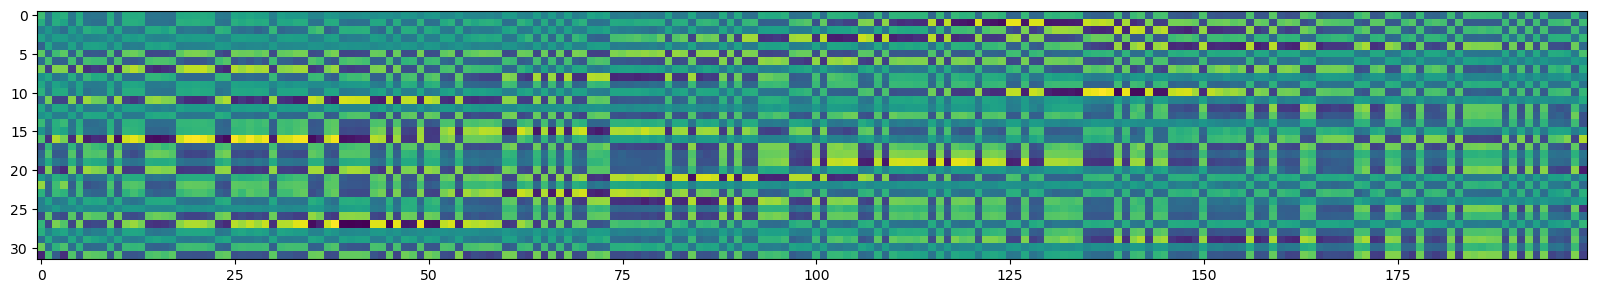

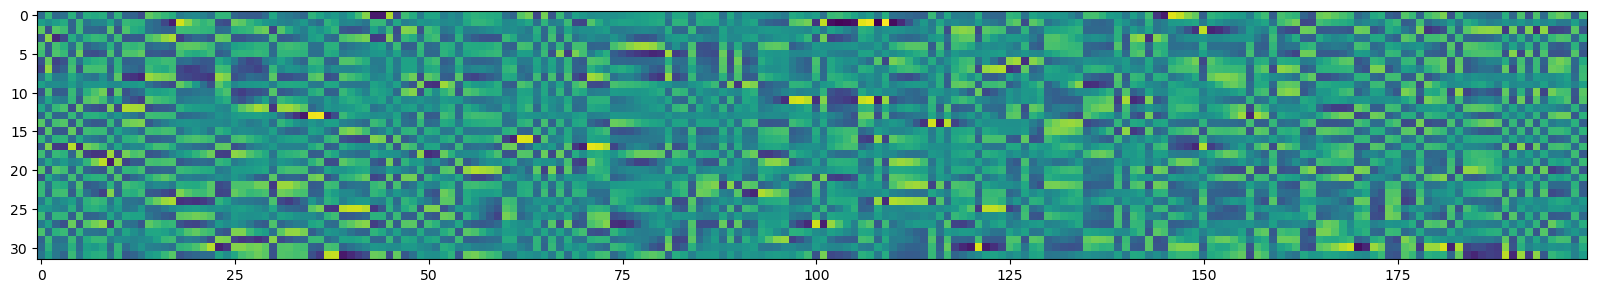

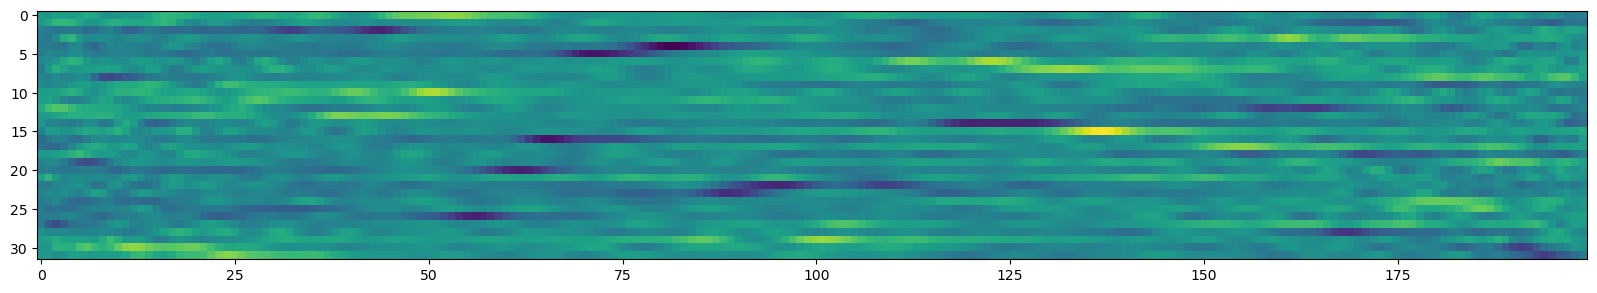

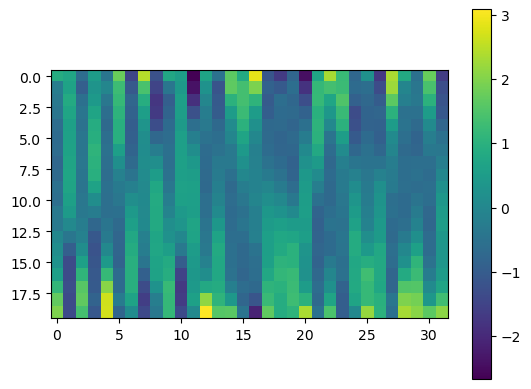

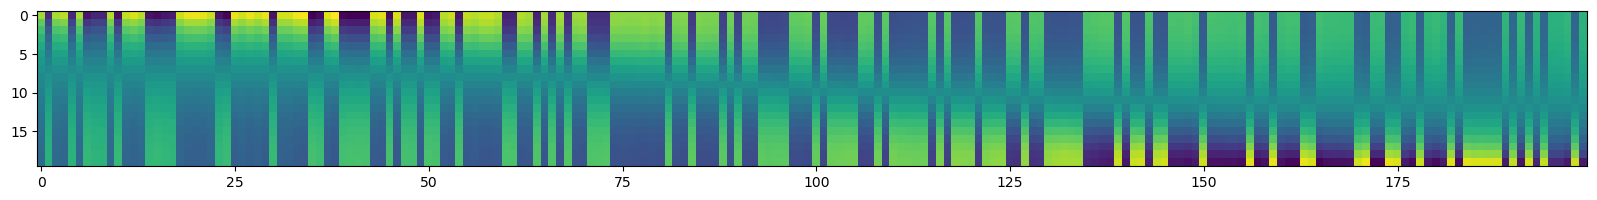

In [28]:
plt.figure(figsize = (20, 30))
im = plt.imshow(tran.value.weight.detach().cpu().numpy())
# plt.colorbar(im)
plt.figure(figsize = (20, 30))
im = plt.imshow(tran.key.weight.detach().cpu().numpy())
# plt.colorbar(im)
plt.figure(figsize = (20, 30))
im = plt.imshow(tran.query.weight.detach().cpu().numpy())
# plt.colorbar(im)
plt.figure()
im = plt.imshow(tran.proj.weight.detach().cpu().numpy())
plt.colorbar(im)
plt.figure(figsize = (20, 30))
im = plt.imshow(tran.proj.weight.detach().cpu().numpy() @ tran.value.weight.detach().cpu().numpy())

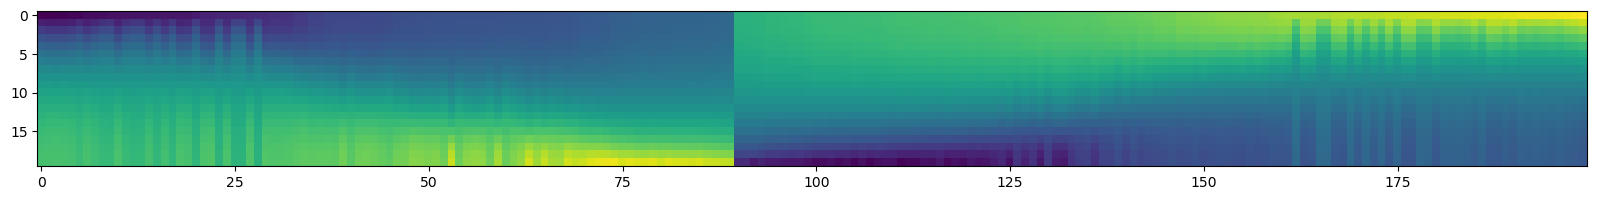

In [31]:
plt.figure(figsize = (20, 30))
index = np.argsort((tran.proj.weight.detach().cpu().numpy() @ tran.value.weight.detach().cpu().numpy())[0, :])
im = plt.imshow(tran.proj.weight.detach().cpu().numpy() @ tran.value.weight.detach().cpu().numpy()[:, index])